# Japanese EDAチュートリアル
このノートブックでは、スタンフォード RNA 3D フォールディング競合データを調査し、RNA 3D 構造を予測するためのベースライン モデルを実装します。

この課題は、RNA分子のヌクレオチド配列のみに基づいて、5種類の3D立体構造を予測することです。このノートには以下のことが書かれています。

- データセットの構造とプロパティを探索する
- RNA配列と3D座標を解析する
- RNA分子のさまざまな構造を視覚化します
- 妥当なRNA構造を生成する簡略化されたベースラインモデルを実装する

In [36]:
# 基本ライブラリ (いつもの)
import os
from pathlib import Path

# EDA (いつもの)
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ビジュアライゼーションのセッティング
plt.rcParams['figure.figsize'] = (12, 8)

### 各データセットのファイル詳細
- train_sequences.csv: トレーニング用のRNA配列
- train_labels.csv: トレーニング用のターゲットラベル
- validation_sequences.csv: バリデーション用のRNA配列
- validation_labels.csv: バリデーション用のターゲットラベル
- test_sequences.csv: テスト用のRNA配列
- sample_submission.csv: 提出ファイルの例

In [ ]:
# データロード
BASE_DIR = "./data"  # データが格納されているベースディレクトリ
TRAIN_SEQ_PATH = BASE_DIR + "/train_sequences.csv"  # トレーニング配列データのパス
TRAIN_LABELS = BASE_DIR + "/train_labels.csv"  # トレーニングラベルデータのパス

# トレーニングデータを読み込む
train_seq_df = pd.read_csv(TRAIN_SEQ_PATH)
train_label_df = pd.read_csv(TRAIN_LABELS)

# トレーニングデータのIDの一致を確認する
print("\nCheck if train_sequences and train_labels have the same IDs:")
print(f"Unique IDs in train_sequences: {train_seq_df['target_id'].nunique()}")  # train_sequences内の一意なtarget_idの数を表示
print(f"Unique IDs in train_labels: {train_label_df['ID'].nunique()}")  # train_labels内の一意なIDの数を表示
# train_sequencesのtarget_idがtrain_labelsのID（プレフィックス）と一致する数を確認
# IDは 'targetid_構造番号' の形式なので、'_' で分割して比較
print(f"Train sequence IDs that match with labels: {sum(train_seq_df['target_id'].isin(train_label_df['ID'].str.split('_').str[0] + '_' + train_label_df['ID'].str.split('_').str[1]))}")

# 検証データを読み込む
val_seq_df = pd.read_csv(Path(BASE_DIR) / 'validation_sequences.csv')
print("\nValidation sequences shape:", val_seq_df.shape)  # 検証配列データの形状を表示
print("\nValidation sequences preview:")
display(val_seq_df.head())  # 検証配列データの最初の数行を表示

# 検証ラベルデータを読み込む
val_labels_df = pd.read_csv(Path(BASE_DIR) / 'validation_labels.csv')
print("\nValidation labels shape:", val_labels_df.shape)  # 検証ラベルデータの形状を表示
print("\nValidation labels preview:")
display(val_labels_df.head())  # 検証ラベルデータの最初の数行を表示

# テストデータを読み込む
test_seq_df = pd.read_csv(Path(BASE_DIR) / 'test_sequences.csv')
print("\nTest sequences shape:", test_seq_df.shape)  # テスト配列データの形状を表示
print("\nTest sequences preview:")
display(test_seq_df.head())  # テスト配列データの最初の数行を表示

# サンプル提出データを読み込む
sample_sub_df = pd.read_csv(Path(BASE_DIR) / 'sample_submission.csv')
print("\nSample submission shape:", sample_sub_df.shape)  # サンプル提出データの形状を表示
print("\nSample submission preview:")
display(sample_sub_df.head())  # サンプル提出データの最初の数行を表示


Check if train_sequences and train_labels have the same IDs:
Unique IDs in train_sequences: 844
Unique IDs in train_labels: 137095
Train sequence IDs that match with labels: 844

Validation sequences shape: (12, 5)

Validation sequences preview:


,target_id,sequence,temporal_cutoff,description,all_sequences
0,R1107,GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUU...,2022-05-28,CPEB3 ribozyme\nHuman\nhuman CPEB3 HDV-like ri...,>7QR4_1|Chain A|U1 small nuclear ribonucleopro...
1,R1108,GGGGGCCACAGCAGAAGCGUUCACGUCGCGGCCCCUGUCAGCCAUU...,2022-05-27,CPEB3 ribozyme\nChimpanzee\nChimpanzee CPEB3 H...,">7QR3_1|Chains A, B|U1 small nuclear ribonucle..."
2,R1116,CGCCCGGAUAGCUCAGUCGGUAGAGCAGCGGCUAAAACAGCUCUGG...,2022-06-04,Cloverleaf RNA\nPoliovirus\nCrystal Structure ...,">8S95_1|Chain A[auth C]|Lysine tRNA scaffold,P..."
3,R1117v2,UUGGGUUCCCUCACCCCAAUCAUAAAAAGG,2022-06-03,PreQ1 class I type III riboswitch\nK. pneumoni...,">8FZA_1|Chains A, B|PreQ1 Riboswitch (30-MER)|..."
4,R1126,GGAAUCUCGCCCGAUGUUCGCAUCGGGAUUUGCAGGUCCAUGGAUU...,2022-06-11,Traptamer\nSynthetic\nAdditional Information: ...,>8TVZ_1|Chain A[auth C]|RNA (363-MER)|syntheti...



Validation labels shape: (2515, 123)

Validation labels preview:


,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,...,z_37,x_38,y_38,z_38,x_39,y_39,z_39,x_40,y_40,z_40
0,R1107_1,G,1,-5.499,8.520000,8.605000,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18
1,R1107_2,G,2,-5.826,10.453000,14.010000,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18
2,R1107_3,G,3,-5.849,14.768000,17.584999,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18
3,R1107_4,G,4,-5.784,19.985001,18.666000,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18
4,R1107_5,G,5,-5.755,25.533001,17.132999,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18



Test sequences shape: (12, 5)

Test sequences preview:


,target_id,sequence,temporal_cutoff,description,all_sequences
0,R1107,GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUU...,2022-05-28,CPEB3 ribozyme\nHuman\nhuman CPEB3 HDV-like ri...,>7QR4_1|Chain A|U1 small nuclear ribonucleopro...
1,R1108,GGGGGCCACAGCAGAAGCGUUCACGUCGCGGCCCCUGUCAGCCAUU...,2022-05-27,CPEB3 ribozyme\nChimpanzee\nChimpanzee CPEB3 H...,">7QR3_1|Chains A, B|U1 small nuclear ribonucle..."
2,R1116,CGCCCGGAUAGCUCAGUCGGUAGAGCAGCGGCUAAAACAGCUCUGG...,2022-06-04,Cloverleaf RNA\nPoliovirus\nCrystal Structure ...,">8S95_1|Chain A[auth C]|Lysine tRNA scaffold,P..."
3,R1117v2,UUGGGUUCCCUCACCCCAAUCAUAAAAAGG,2022-06-03,PreQ1 class I type III riboswitch\nK. pneumoni...,">8FZA_1|Chains A, B|PreQ1 Riboswitch (30-MER)|..."
4,R1126,GGAAUCUCGCCCGAUGUUCGCAUCGGGAUUUGCAGGUCCAUGGAUU...,2022-06-11,Traptamer\nSynthetic\nAdditional Information: ...,>8TVZ_1|Chain A[auth C]|RNA (363-MER)|syntheti...



Sample submission shape: (2515, 18)

Sample submission preview:


,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5
0,R1107_1,G,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,R1107_2,G,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,R1107_3,G,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,R1107_4,G,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,R1107_5,G,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## データセットの構造分析

### トレーニングデータ
- train_sequences.csv(844, 5)
    - 列: target_id, sequence, temporal_cutoff, description, all_sequences
    - 行: 固有のRNA分子
- train_labels.csv
    - 列: ID, resname, resid, x_1, y_1, z_1
    - 行: ヌクレオチド基とその3D座標
    - note: 座標列に約6,145個の欠損値が存在する。

### 検証データ
- validation_sequences.csv(12, 5)
    - 列: target_id, sequence, temporal_cutoff, description, all_sequences
    - 行: 固有のRNA分子
- validation_labels.csv : (2,515, 123)
    - 列: x_1、y_1、z_1 から x_40、y_40、z_40 までの座標
    - note: 多くの座標はプレースホルダー値（-1.0e+18）で埋められている

### テストデータ¶
- test_sequences.csv(12, 5)
    - 列: target_id, sequence, temporal_cutoff, description, all_sequences
    - 行: 固有のRNA分子
- sample_submission.csv : (2,515, 18)
    - 列: ID、resname、resid、x_1、y_1、z_1、x_2、y_2、z_2、x_3、y_3、z_3、x_4、y_4、z_4、x_5、y_5、z_5


### ここからわかること
- 844個のtrain_sequences IDはすべてtrain_labelsのエントリに対応している。
- 検証セットとテストセットは同じRNA配列を持つ
- train_labelsには3D座標(x_1, y_1, z_1)が1セットしかなく、validation_labelsには40セットある
- 提出フォーマットには5セットの3D座標が必要

## RNA配列解析
RNA配列を分析してその特性を理解します。
- 長さの分布
- ヌクレオチド組織
- 時間分布

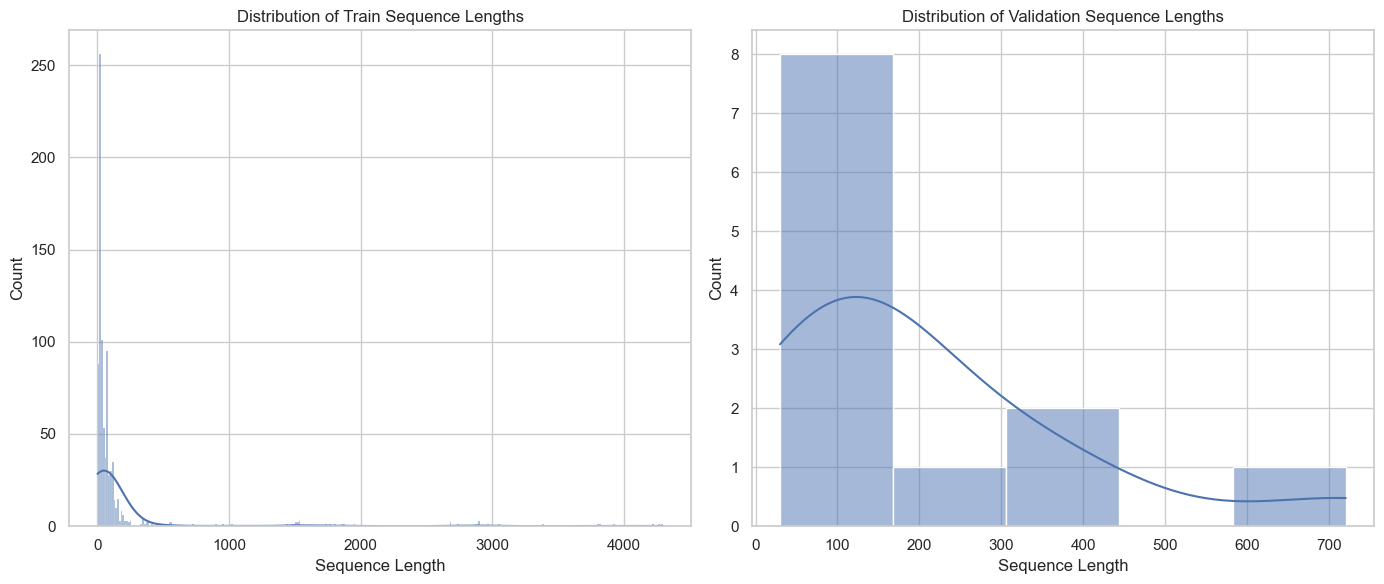

In [33]:
train_seq_df['seq_length'] = train_seq_df['sequence'].apply(len)
val_seq_df['seq_length'] = val_seq_df['sequence'].apply(len)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(train_seq_df['seq_length'], kde=True)
plt.title('Distribution of Train Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(val_seq_df['seq_length'], kde=True)
plt.title('Distribution of Validation Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


Nucleotide composition in training data:


,count,percentage
A,32524,23.724734
C,33937,24.755451
G,41450,30.235832
U,29178,21.283983



Sequence length statistics (Training):
count     844.000000
mean      162.434834
std       515.031957
min         3.000000
25%        22.000000
50%        39.500000
75%        86.000000
max      4298.000000
Name: seq_length, dtype: float64

Sequence length statistics (Validation):
count     12.000000
mean     209.583333
std      194.493963
min       30.000000
25%      105.750000
50%      129.500000
75%      269.250000
max      720.000000
Name: seq_length, dtype: float64


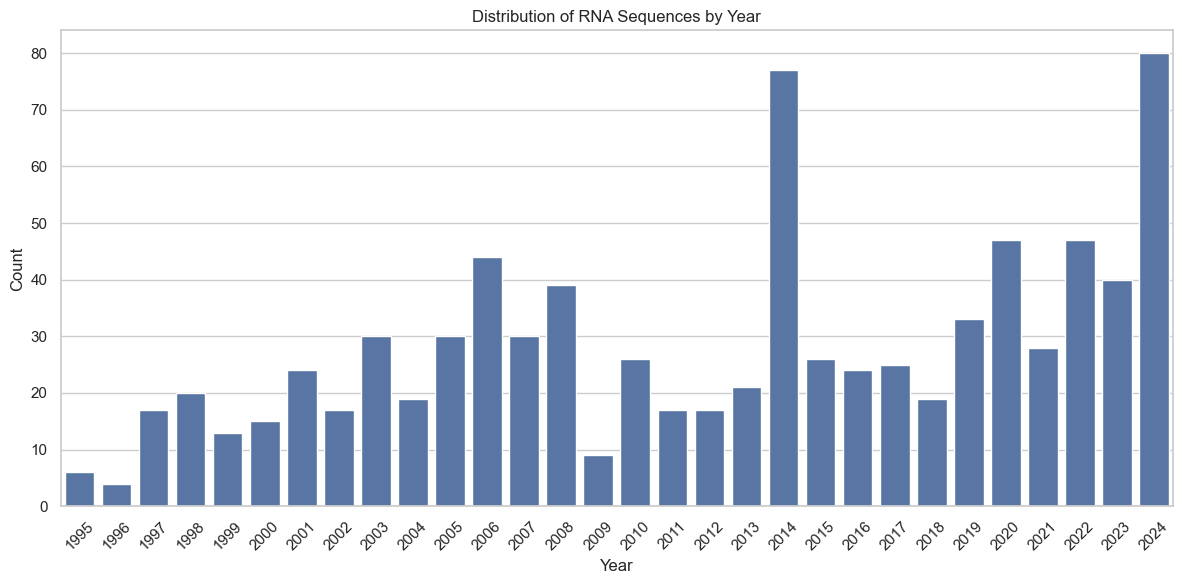

In [ ]:
def nucleotide_composition(seq):
    return {
        'A': seq.count('A'),
        'C': seq.count('C'),
        'G': seq.count('G'),
        'U': seq.count('U')
    }

train_nucleotides = train_seq_df['sequence'].apply(nucleotide_composition).apply(pd.Series)
train_composition = pd.DataFrame({
    'A': train_nucleotides['A'].sum(),
    'C': train_nucleotides['C'].sum(),
    'G': train_nucleotides['G'].sum(),
    'U': train_nucleotides['U'].sum()
}, index=['count'])
train_composition = train_composition.T
train_composition['percentage'] = 100 * train_composition['count'] / train_composition['count'].sum()

print("\nNucleotide composition in training data:")
display(train_composition)

print("\nSequence length statistics (Training):")
print(train_seq_df['seq_length'].describe())

print("\nSequence length statistics (Validation):")
print(val_seq_df['seq_length'].describe())

train_seq_df['year'] = pd.to_datetime(train_seq_df['temporal_cutoff']).dt.year
plt.figure(figsize=(12, 6))
sns.countplot(x='year', data=train_seq_df)
plt.title('Distribution of RNA Sequences by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## RNA配列と構造解析

## シーケンスの長さと構成の分析

### シーケンス長分布
- **トレーニングデータ**  
  - ほとんどの配列は短い（中央値 **39.5ヌクレオチド**）
  - 非常に偏った分布を示す
  - 長さの範囲：**3～4298ヌクレオチド**
  - 配列の75%は**86ヌクレオチド未満**

- **検証データ**  
  - 平均長は**129.5ヌクレオチド**
  - より均等な分布を示す
  - 長さの範囲：**30～720ヌクレオチド**

- **テストデータ**  
  - テストシーケンスは検証シーケンスと同様の分布を持つ

### ヌクレオチド組成
- **G（グアニン）**：30.24%
- **C（シトシン）**：24.76%
- **A（アデニン）**：23.72%
- **U（ウラシル）**：21.28%

### 時間分布
- データ収集期間は**1995年～2024年**
- **2013年**と**2024年**に顕著な急増が見られる
- テスト・検証データは主に**2022年**に収集されたものであり、トレーニングデータより新しい


### タスクの理解

このコンテストの目的は、**RNA配列に対応する3D座標を予測する**ことです。

- **トレーニングラベル**  
  - 各配列に対して1セットの座標情報（x₁, y₁, z₁）が付与されている

- **検証ラベル**  
  - 各配列に対して**40セット**の座標情報（x₁〜x₄₀, y₁〜y₄₀, z₁〜z₄₀）が付与されている

- **提出フォーマット**  
  - 各配列に対して**5セット**の座標（x₁〜x₅, y₁〜y₅, z₁〜z₅）を予測して提出する必要がある

> これは、**1つのRNA配列が複数の可能な3Dコンフォメーション（立体構造）を持つ**ことを示唆しています。

## RNA 3D構造解析

RNA配列の座標を視覚化・解析することにより、  
**RNAがどのようにして3D構造へと折り畳まれていくか**を調べていきます。

Understanding the multiple coordinate sets in validation data:
Columns with actual coordinate data: ['x_1', 'y_1', 'z_1']
RNA ID: 1SCL_A
Description: THE SARCIN-RICIN LOOP, A MODULAR RNA...
Sequence length: 29
Sequence: GGGUGCUCAGUACGAGAGGAACCGCACCC
Number of residues with coordinates: 29
Residues with missing coordinates: 0


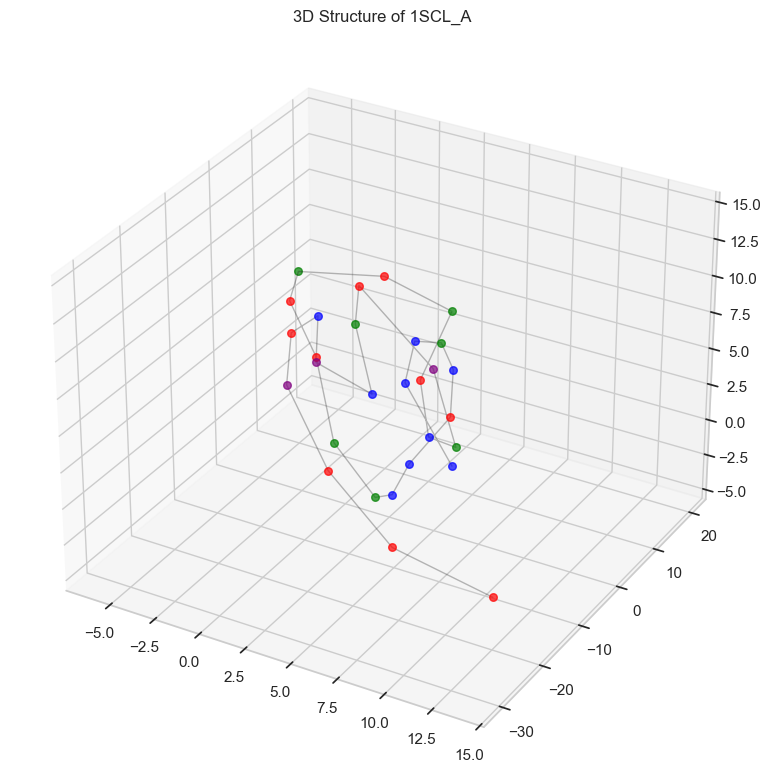


Coordinate statistics:


,x_1,y_1,z_1
count,29.000000,29.000000,29.00000
mean,3.632655,-6.592448,5.23669
std,4.953478,15.555890,5.27883
min,-6.051000,-30.907000,-4.33300
25%,1.107000,-20.136000,1.13000
50%,2.678000,-6.406000,5.22400
75%,7.931000,4.792000,9.64500
max,13.760000,20.115000,14.30800



Average distance between consecutive residues: 5.49 Å
Min distance: 4.18 Å, Max distance: 7.23 Å


In [37]:
residue_colors = {'A': 'green', 'C': 'blue', 'G': 'red', 'U': 'purple'}

def analyze_rna_structure(target_id, labels_df, seq_df):
    
    seq_info = seq_df[seq_df['target_id'] == target_id].iloc[0]
    sequence = seq_info['sequence']
    print(f"RNA ID: {target_id}")
    print(f"Description: {seq_info['description'][:100]}...")
    print(f"Sequence length: {len(sequence)}")
    print(f"Sequence: {sequence[:50]}..." if len(sequence) > 50 else f"Sequence: {sequence}")
    
    struct_data = labels_df[labels_df['ID'].str.startswith(target_id)]
    print(f"Number of residues with coordinates: {len(struct_data)}")
    
    missing_coords = struct_data[['x_1', 'y_1', 'z_1']].isna().any(axis=1).sum()
    print(f"Residues with missing coordinates: {missing_coords}")
    
    if len(struct_data) > 0 and missing_coords < len(struct_data):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        for idx, row in struct_data.iterrows():
            if not pd.isna(row['x_1']) and not pd.isna(row['y_1']) and not pd.isna(row['z_1']):
                color = residue_colors.get(row['resname'], 'black')
                ax.scatter(row['x_1'], row['y_1'], row['z_1'], c=color, s=30, alpha=0.7)
        
        xs = struct_data['x_1'].dropna().values
        ys = struct_data['y_1'].dropna().values
        zs = struct_data['z_1'].dropna().values
        if len(xs) > 1:
            ax.plot(xs, ys, zs, 'k-', alpha=0.3, linewidth=1)
        
        ax.set_title(f'3D Structure of {target_id}')
        plt.tight_layout()
        plt.show()
    
    if missing_coords < len(struct_data):
        coord_stats = struct_data[['x_1', 'y_1', 'z_1']].describe()
        print("\nCoordinate statistics:")
        display(coord_stats)
        
        dists = []
        for i in range(len(struct_data) - 1):
            row1 = struct_data.iloc[i]
            row2 = struct_data.iloc[i+1]
            if not pd.isna(row1['x_1']) and not pd.isna(row2['x_1']):
                dist = np.sqrt((row1['x_1'] - row2['x_1'])**2 + 
                               (row1['y_1'] - row2['y_1'])**2 + 
                               (row1['z_1'] - row2['z_1'])**2)
                dists.append(dist)
        
        if dists:
            print(f"\nAverage distance between consecutive residues: {np.mean(dists):.2f} Å")
            print(f"Min distance: {np.min(dists):.2f} Å, Max distance: {np.max(dists):.2f} Å")

print("Understanding the multiple coordinate sets in validation data:")
val_example = val_labels_df[val_labels_df['ID'] == val_labels_df['ID'].iloc[0]]

non_missing_cols = []
for col in val_example.columns:
    if col.startswith('x_') or col.startswith('y_') or col.startswith('z_'):
        if (val_example[col] != -1.0e+18).any():
            non_missing_cols.append(col)

print(f"Columns with actual coordinate data: {non_missing_cols}")

short_example = train_seq_df[train_seq_df['seq_length'] < 30].iloc[0]['target_id']
analyze_rna_structure(short_example, train_label_df, train_seq_df)

## RNA 3D構造解析

### サンプル構造解析（1SCL_A）

- **配列情報**  
  - 長さ：29ヌクレオチド  
  - 配列：`GGGUGCUCAGUACGAGAGGAACCGCACCC`

- **ヌクレオチド組成**  
  - **G（グアニン）**：41%  
  - **C（シトシン）**：28%  
  - **A（アデニン）**：14%  
  - **U（ウラシル）**：17%

- **3D構造の特徴**  
  - 明確な空間構成を持つコンパクトな折り畳み構造
  - **座標範囲**  
    - X軸：-6.05 ～ 13.76 Å  
    - Y軸：-30.91 ～ 20.12 Å  
    - Z軸：-4.33 ～ 14.31 Å

- **残基間距離**  
  - 連続するヌクレオチド間の**平均距離**：5.49 Å  
  - 最小距離：4.18 Å  
  - 最大距離：7.23 Å

### 重要な考察

- 検証データには**40セット**の構造情報が存在する一方で、  
  **x₁、y₁、z₁**のみの列しかない場合もあり、データ形式に注意が必要です。

- このコンテストでは、**同じRNA配列に対して複数（提出では5つ）の3Dコンフォメーション**を予測する必要があります。

- RNAの**連続した残基間距離がほぼ一貫して約5〜6Å**であることは、  
  構造予測モデルの設計や学習において重要な手がかりとなる可能性があります。


Coordinate statistics for different RNA structures:


,RNA_ID,Sequence_Length,X_Range,Y_Range,Z_Range,Avg_Residue_Distance
0,5LSN_A,29,35.129999,22.810000,31.615000,5.579680
0,4TUA_XY,17,18.476006,25.447000,17.058002,5.691665
0,5XJ2_G,10,16.703001,12.891001,12.368996,6.271269
0,2FEY_A,43,22.619000,68.903000,16.077000,5.538608
0,8CTI_C,73,29.673004,54.288010,63.057999,6.160327
0,8WT6_F,180,98.376007,40.954994,37.966003,6.317437
0,6WLO_A,338,89.527992,104.505993,153.312992,5.812499
0,7X34_3,130,97.936005,54.209991,153.209000,5.646284


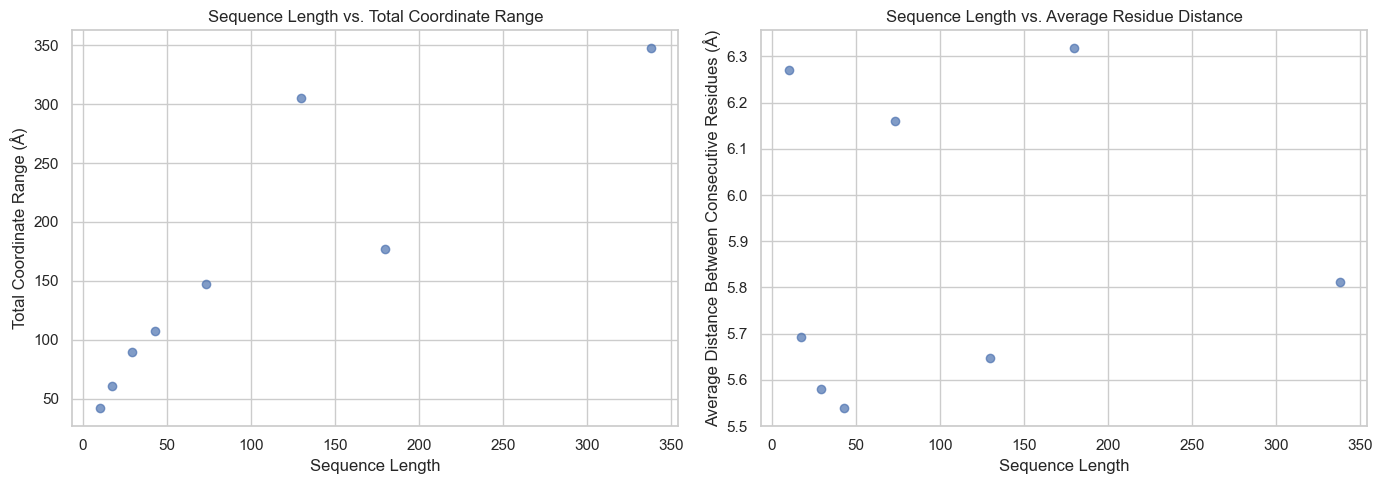


Comparing sequence properties between training and validation/test data:
                 Avg_Length  GC_Content  Latest_Year       Has_U
Training         162.434834   55.243941       2024.0   98.341232
Validation/Test  209.583333   57.431690       2022.0  100.000000


In [38]:
# Let's select a few more examples from training data with different lengths
medium_example = train_seq_df[(train_seq_df['seq_length'] > 50) & (train_seq_df['seq_length'] < 100)].iloc[0]['target_id']
long_example = train_seq_df[train_seq_df['seq_length'] > 200].iloc[0]['target_id']

# Compare coordinate distributions across different structures 
def compare_coordinate_distributions():
    # Create a dataframe to store statistics for each RNA structure
    stats_df = pd.DataFrame()
    
    # Sample a few structures of different lengths
    sample_ids = []
    
    # Short sequences (< 30 nucleotides)
    short_samples = train_seq_df[train_seq_df['seq_length'] < 30].sample(min(3, len(train_seq_df[train_seq_df['seq_length'] < 30])))
    sample_ids.extend(short_samples['target_id'].tolist())
    
    # Medium sequences (30-100 nucleotides)
    medium_samples = train_seq_df[(train_seq_df['seq_length'] >= 30) & (train_seq_df['seq_length'] <= 100)].sample(min(3, len(train_seq_df[(train_seq_df['seq_length'] >= 30) & (train_seq_df['seq_length'] <= 100)])))
    sample_ids.extend(medium_samples['target_id'].tolist())
    
    # Long sequences (> 100 nucleotides)
    long_samples = train_seq_df[train_seq_df['seq_length'] > 100].sample(min(3, len(train_seq_df[train_seq_df['seq_length'] > 100])))
    sample_ids.extend(long_samples['target_id'].tolist())
    
    # Calculate statistics for each structure
    for target_id in sample_ids:
        seq_len = train_seq_df[train_seq_df['target_id'] == target_id].iloc[0]['seq_length']
        struct_data = train_label_df[train_label_df['ID'].str.startswith(target_id)]
        
        # Skip if no valid coordinates
        if struct_data[['x_1', 'y_1', 'z_1']].isna().all().any():
            continue
        
        # Calculate coordinate range
        x_range = struct_data['x_1'].max() - struct_data['x_1'].min()
        y_range = struct_data['y_1'].max() - struct_data['y_1'].min()
        z_range = struct_data['z_1'].max() - struct_data['z_1'].min()
        
        # Calculate average distances between consecutive residues
        dists = []
        for i in range(len(struct_data) - 1):
            row1 = struct_data.iloc[i]
            row2 = struct_data.iloc[i+1]
            if not pd.isna(row1['x_1']) and not pd.isna(row2['x_1']):
                dist = np.sqrt((row1['x_1'] - row2['x_1'])**2 + 
                               (row1['y_1'] - row2['y_1'])**2 + 
                               (row1['z_1'] - row2['z_1'])**2)
                dists.append(dist)
        
        avg_dist = np.mean(dists) if dists else np.nan
        
        # Add to stats dataframe
        stats_df = pd.concat([stats_df, pd.DataFrame({
            'RNA_ID': [target_id],
            'Sequence_Length': [seq_len],
            'X_Range': [x_range],
            'Y_Range': [y_range],
            'Z_Range': [z_range],
            'Avg_Residue_Distance': [avg_dist]
        })])
    
    return stats_df

# Compare coordinate distributions
coord_stats = compare_coordinate_distributions()
print("Coordinate statistics for different RNA structures:")
display(coord_stats)

# Visualize relationship between sequence length and coordinate ranges
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(coord_stats['Sequence_Length'], coord_stats['X_Range'] + coord_stats['Y_Range'] + coord_stats['Z_Range'], alpha=0.7)
plt.title('Sequence Length vs. Total Coordinate Range')
plt.xlabel('Sequence Length')
plt.ylabel('Total Coordinate Range (Å)')

plt.subplot(1, 2, 2)
plt.scatter(coord_stats['Sequence_Length'], coord_stats['Avg_Residue_Distance'], alpha=0.7)
plt.title('Sequence Length vs. Average Residue Distance')
plt.xlabel('Sequence Length')
plt.ylabel('Average Distance Between Consecutive Residues (Å)')

plt.tight_layout()
plt.show()

# Now let's analyze what makes the validation/test data different
# Let's compare the sequence properties of train vs. validation
print("\nComparing sequence properties between training and validation/test data:")
train_properties = {}
train_properties['Avg_Length'] = train_seq_df['seq_length'].mean()
train_properties['GC_Content'] = train_seq_df['sequence'].apply(lambda x: (x.count('G') + x.count('C')) / len(x) * 100).mean()
train_properties['Latest_Year'] = train_seq_df['year'].max()
train_properties['Has_U'] = train_seq_df['sequence'].apply(lambda x: 'U' in x).mean() * 100

val_properties = {}
val_properties['Avg_Length'] = val_seq_df['seq_length'].mean()
val_properties['GC_Content'] = val_seq_df['sequence'].apply(lambda x: (x.count('G') + x.count('C')) / len(x) * 100).mean()
# Extract year from val_seq temporal_cutoff
val_seq_df['year'] = pd.to_datetime(val_seq_df['temporal_cutoff']).dt.year
val_properties['Latest_Year'] = val_seq_df['year'].max()
val_properties['Has_U'] = val_seq_df['sequence'].apply(lambda x: 'U' in x).mean() * 100

compare_df = pd.DataFrame({'Training': train_properties, 'Validation/Test': val_properties}).T
print(compare_df)

## RNA 3D構造予測の詳細

### これまでの主な観察事項

#### 配列と構造の関係
- 総座標範囲は**配列の長さに比例して増加**する傾向が見られる
- **連続する残基間の平均距離**は、配列長に関係なく**一定**（約5.4〜6.2 Å）

#### トレーニングデータと検証データの比較
- **配列の長さ**  
  - 検証データの方がわずかに長い  
    （検証データ：平均210ヌクレオチド、トレーニングデータ：平均162ヌクレオチド）
- **GC含有量**  
  - 検証データのGC含有量はやや高い  
    （検証データ：57.4%、トレーニングデータ：55.2%）
- **データの年代**  
  - 検証データは比較的新しい（主に2022年）、  
    トレーニングデータは1995年から2024年まで幅広く含まれる
- **ヌクレオチド組成**  
  - 検証データでは、すべての配列に**ウラシル（U）**が含まれている

### コンペティションタスクの理解

- 各RNA配列に対して、**5つの異なる3Dコンフォメーション**を予測する必要がある
- 各残基ごとに、**5通りのx、y、z座標**が求められる

> つまり、1つのRNA配列に対して、空間配置の多様性を表現できる複数の構造を生成することが求められている


In [ ]:
print("Analyzing validation labels format:")
print(f"Columns in validation_labels: {val_labels_df.columns.tolist()[:10]}... (total {len(val_labels_df.columns)})")

val_coords = [col for col in val_labels_df.columns if col.startswith('x_') or col.startswith('y_') or col.startswith('z_')]
print(f"\nTotal coordinate columns: {len(val_coords)} ({val_coords[:6]}...)")

conformation_counts = {}
for i in range(1, 41):
    cols = [f'x_{i}', f'y_{i}', f'z_{i}']
    valid_count = (val_labels_df[cols[0]] != -1.0e+18).sum()
    if valid_count > 0:
        conformation_counts[i] = valid_count

print("\nValid coordinates per conformation:")
for conf, count in conformation_counts.items():
    print(f"Conformation {conf}: {count} residues")

val_ids = val_labels_df['ID'].unique()

print("\nAnalyzing residue distributions:")
example_id = val_labels_df['ID'].unique()[0].split('_')[0]
example_data = val_labels_df[val_labels_df['ID'].str.startswith(example_id)]
print(f"Residue counts for {example_id}:")
print(example_data['resname'].value_counts())

Analyzing validation labels format:
Columns in validation_labels: ['ID', 'resname', 'resid', 'x_1', 'y_1', 'z_1', 'x_2', 'y_2', 'z_2', 'x_3']... (total 123)

Total coordinate columns: 120 (['x_1', 'y_1', 'z_1', 'x_2', 'y_2', 'z_2']...)

Valid coordinates per conformation:
Conformation 1: 2500 residues
Conformation 2: 1077 residues
Conformation 3: 259 residues
Conformation 4: 259 residues
Conformation 5: 259 residues
Conformation 6: 259 residues
Conformation 7: 259 residues
Conformation 8: 259 residues
Conformation 9: 259 residues
Conformation 10: 259 residues
Conformation 11: 135 residues
Conformation 12: 135 residues
Conformation 13: 135 residues
Conformation 14: 135 residues
Conformation 15: 135 residues
Conformation 16: 135 residues
Conformation 17: 135 residues
Conformation 18: 135 residues
Conformation 19: 135 residues
Conformation 20: 135 residues
Conformation 21: 135 residues
Conformation 22: 135 residues
Conformation 23: 135 residues
Conformation 24: 135 residues
Conformation 2

## スタンフォードRNA 3Dフォールディングコンペティション：タスク理解

### 主な発見

#### 検証データにおける複数のコンフォメーション
- 検証データには、各RNA配列に対して最大**40種類**の異なる3D構造が含まれている
- 構造ごとに異なる数の有効な座標数：
  - **セット1**（x₁, y₁, z₁）：2500残基
  - **セット2**（x₂, y₂, z₂）：1077残基
  - **セット3〜10**：各259残基
  - **セット11〜40**：各135残基

#### 競技目標
- テストシーケンスに対して、**最初の5つのコンフォメーション**を予測する必要がある
- 提出ファイルには、**5つすべてのコンフォメーション**の座標情報を含める
- 各予測には、RNA内の**すべての残基**に対する**x、y、z座標**を含める必要がある

---

#### データ構造に関する洞察

- **トレーニングデータ**  
  - 各配列に対して**1つのコンフォメーション**のみが提供されている

- **検証データ**  
  - 各配列に対して**40の可能なコンフォメーション**が存在する

- **テストデータ**  
  - テストシーケンスは検証シーケンスと一致しており、  
    **アンサンブル予測タスク**（＝1配列に対して複数構造を予測）であることが示唆される

---

### ヌクレオチド分布（検証例 RNA: R1107）

- **シトシン（C）**：24残基
- **グアニン（G）**：20残基
- **ウラシル（U）**：13残基
- **アデニン（A）**：12残基



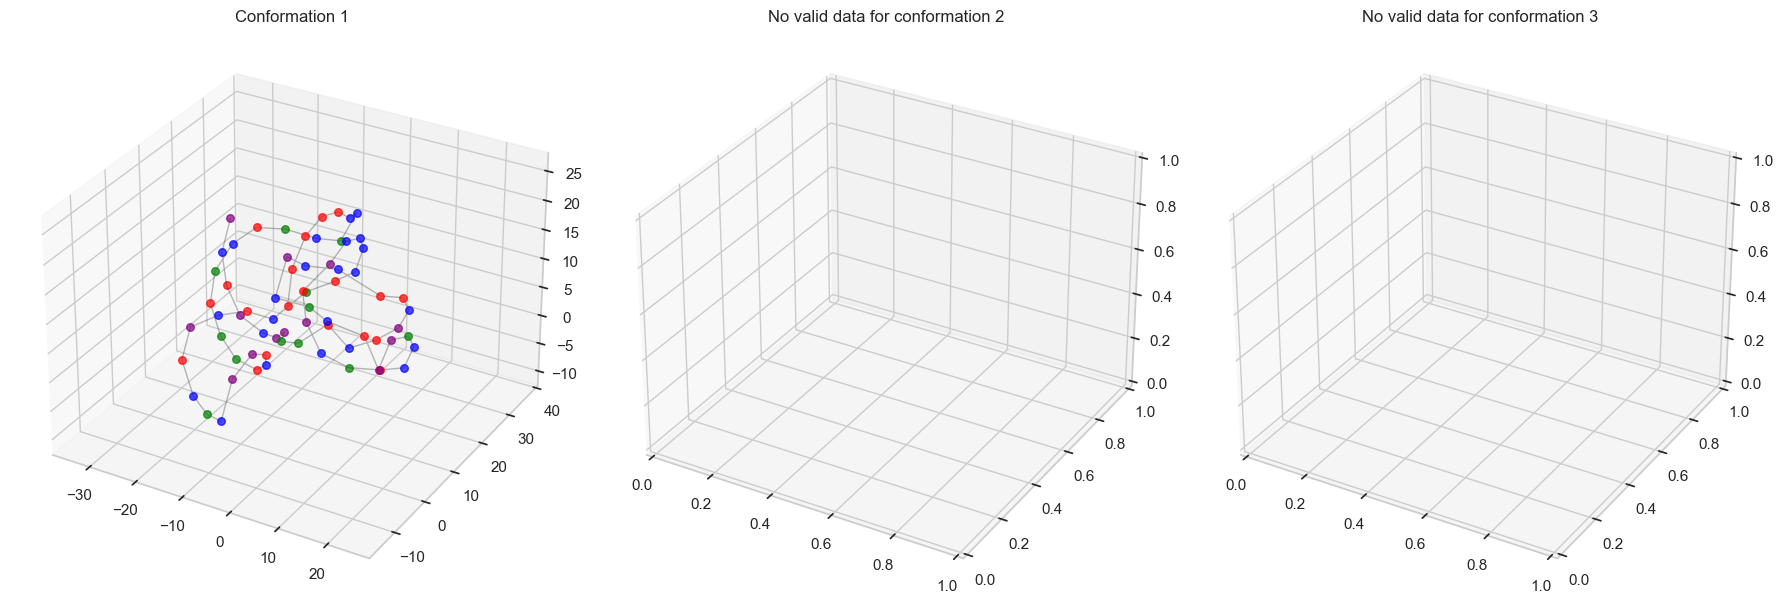

RMSD Analysis for R1107:

Analyzing number of residues per RNA sequence:
         Residue_Count
R1107               69
R1108               69
R1116              157
R1117v2             30
R1126              363
R1128              238
R1136              374
R1138              720
R1149              124
R1156              135
R1189              118
R1190              118

Comparing sequence length vs. number of residues in 3D structure:
         Residue_Count  Sequence_Length
R1107               69               69
R1108               69               69
R1116              157              157
R1117v2             30               30
R1126              363              363
R1128              238              238
R1136              374              374
R1138              720              720
R1149              124              124
R1156              135              135
R1189              118              118
R1190              118              118

Checking for gaps in residue numbering:


In [42]:
def visualize_multiple_conformations(rna_id, num_conformations=3):
    rna_data = val_labels_df[val_labels_df['ID'].str.startswith(rna_id.split('_')[0])]

    fig = plt.figure(figsize=(18, 6))
   
    for i in range(1, num_conformations + 1):
        ax = fig.add_subplot(1, num_conformations, i, projection='3d')
 
        x_col, y_col, z_col = f'x_{i}', f'y_{i}', f'z_{i}'

        if (rna_data[x_col] == -1.0e+18).all():
            ax.set_title(f'No valid data for conformation {i}')
            continue

        valid_coords = rna_data[(rna_data[x_col] != -1.0e+18) & 
                               (rna_data[y_col] != -1.0e+18) & 
                               (rna_data[z_col] != -1.0e+18)]

        for idx, row in valid_coords.iterrows():
            color = residue_colors.get(row['resname'], 'black')
            ax.scatter(row[x_col], row[y_col], row[z_col], c=color, s=30, alpha=0.7)
  
        coords = valid_coords.sort_values('resid')
        ax.plot(coords[x_col], coords[y_col], coords[z_col], 'k-', alpha=0.3, linewidth=1)
        
        ax.set_title(f'Conformation {i}')
        
    plt.tight_layout()
    plt.show()

    print(f"RMSD Analysis for {rna_id}:")
    rmsd_results = []
    
    for i in range(1, num_conformations):
        for j in range(i+1, num_conformations+1):
            x_col_i, y_col_i, z_col_i = f'x_{i}', f'y_{i}', f'z_{i}'
            x_col_j, y_col_j, z_col_j = f'x_{j}', f'y_{j}', f'z_{j}'
            
            valid_i = rna_data[(rna_data[x_col_i] != -1.0e+18) & 
                              (rna_data[y_col_i] != -1.0e+18) & 
                              (rna_data[z_col_i] != -1.0e+18)]
            
            valid_j = rna_data[(rna_data[x_col_j] != -1.0e+18) & 
                              (rna_data[y_col_j] != -1.0e+18) & 
                              (rna_data[z_col_j] != -1.0e+18)]
            
            common_residues = set(valid_i['resid']).intersection(set(valid_j['resid']))
            
            if common_residues:
                valid_i = valid_i[valid_i['resid'].isin(common_residues)]
                valid_j = valid_j[valid_j['resid'].isin(common_residues)]

                valid_i = valid_i.sort_values('resid')
                valid_j = valid_j.sort_values('resid')

                coords_i = valid_i[[x_col_i, y_col_i, z_col_i]].values
                coords_j = valid_j[[x_col_j, y_col_j, z_col_j]].values
                
                squared_diff = np.sum((coords_i - coords_j) ** 2, axis=1)
                rmsd = np.sqrt(np.mean(squared_diff))
                
                rmsd_results.append({
                    'Conformation_1': i,
                    'Conformation_2': j,
                    'RMSD': rmsd,
                    'Num_Common_Residues': len(common_residues)
                })

    if rmsd_results:
        rmsd_df = pd.DataFrame(rmsd_results)
        display(rmsd_df)

first_rna_id = val_ids[0].split('_')[0]
visualize_multiple_conformations(first_rna_id, num_conformations=3)

print("\nAnalyzing number of residues per RNA sequence:")
residue_counts = {}

for rna_id in val_seq_df['target_id'].unique():
    count = len(val_labels_df[val_labels_df['ID'].str.startswith(rna_id)])
    residue_counts[rna_id] = count

residue_counts_df = pd.DataFrame.from_dict(residue_counts, orient='index', columns=['Residue_Count'])
print(residue_counts_df)

residue_counts_df['Sequence_Length'] = [len(val_seq_df[val_seq_df['target_id'] == idx].iloc[0]['sequence']) for idx in residue_counts_df.index]
print("\nComparing sequence length vs. number of residues in 3D structure:")
print(residue_counts_df)

print("\nChecking for gaps in residue numbering:")
for rna_id in list(val_seq_df['target_id'].unique())[:3]: 
    rna_data = val_labels_df[val_labels_df['ID'].str.startswith(rna_id)]
    resids = sorted(rna_data['resid'].unique())
    
    if max(resids) - min(resids) + 1 != len(resids):
        print(f"RNA {rna_id} has gaps in residue numbering")
        expected_resids = set(range(min(resids), max(resids) + 1))
        actual_resids = set(resids)
        gaps = expected_resids - actual_resids
        print(f"  Missing residue numbers: {sorted(gaps)}")
    else:
        print(f"RNA {rna_id} has continuous residue numbering")

## スタンフォードRNA 3Dフォールディングチャレンジ：問題の完全な理解

### データ構造に関する洞察

#### 配列と構造の関係
- RNA配列中のすべてのヌクレオチドは、3D構造中の**1つの残基**に正確に対応する
- 残基番号は**隙間なく連続**している
- 配列の長さと構造中の残基数は**完全に一致**する

#### 複数のコンフォメーション
- 検証データには**40セット**の座標情報が存在
- しかし実際には、個々のRNAサンプルでは多くの構造において**有効なデータが欠けている**ことが視覚化により判明
- コンフォメーションごとの有効な残基数：
  - **最初のコンフォメーション**（x₁, y₁, z₁）：2500残基（全配列）
  - **後期のコンフォメーション**：部分的なデータしか存在しない、または完全に欠損している場合もある

---

### 競技課題の明確化

- 各RNA配列に対して、**5つの異なる可能な3D構造**を予測する必要がある
- 検証データには最大40の潜在的なコンフォメーションが含まれているが、  
  **最も可能性の高い5つ**を選択・予測することが求められる

---

### RNA構造特性

- **連続する残基間の距離**は比較的一定（約5.4〜6.2 Å）を維持している
- **総座標範囲**は、配列の長さに応じて変動する
- 各残基タイプ（A、C、G、U）は、  
  それぞれ**特徴的な3D配置パターン**を持っていることが観察される


Analyzing RNA structure complexity:

Radius of Gyration statistics (Training):
count    18.000000
mean     22.884861
std      14.380535
min      10.274402
25%      12.690409
50%      17.273805
75%      31.616872
max      64.963926
Name: Radius_of_Gyration, dtype: float64

Radius of Gyration statistics (Validation):
count    12.000000
mean     34.375407
std      12.445868
min      11.760370
25%      29.007285
50%      32.754289
75%      39.737156
max      55.103446
Name: Radius_of_Gyration, dtype: float64


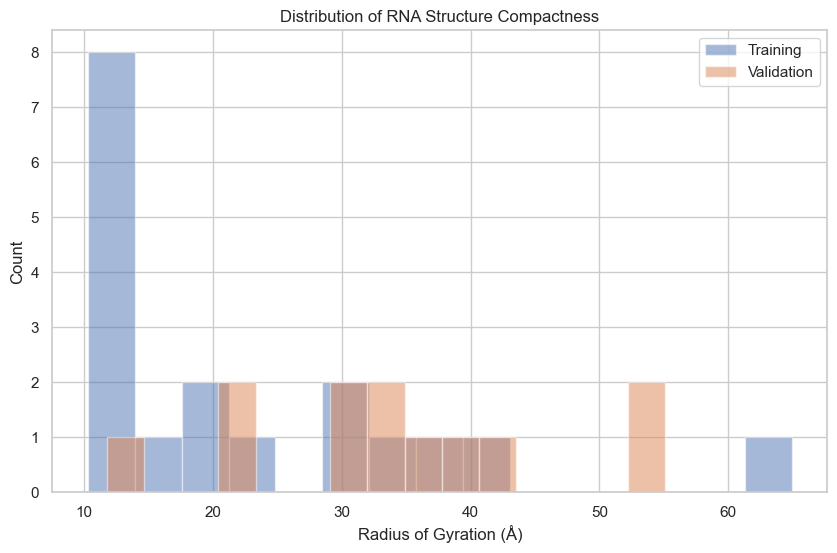

In [45]:
def generate_rotated_conformation(coords, rotation_angle=30, axis='z'):
    """Generate a rotated version of a 3D structure"""
    coords_array = coords.copy().values

    theta = np.radians(rotation_angle)
    if axis == 'x':
        rotation_matrix = np.array([
            [1, 0, 0],
            [0, np.cos(theta), -np.sin(theta)],
            [0, np.sin(theta), np.cos(theta)]
        ])
    elif axis == 'y':
        rotation_matrix = np.array([
            [np.cos(theta), 0, np.sin(theta)],
            [0, 1, 0],
            [-np.sin(theta), 0, np.cos(theta)]
        ])
    else:  
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta), 0],
            [np.sin(theta), np.cos(theta), 0],
            [0, 0, 1]
        ])

    rotated_coords = np.dot(coords_array, rotation_matrix)
    
    return pd.DataFrame(rotated_coords, columns=coords.columns)

print("Analyzing RNA structure complexity:")

def radius_of_gyration(coordinates):
    center = np.mean(coordinates, axis=0)
    distances = np.sqrt(np.sum((coordinates - center)**2, axis=1))
    rg = np.sqrt(np.mean(distances**2))
    return rg

rg_train = []
for target_id in train_seq_df.sample(min(20, len(train_seq_df)))['target_id']:
    struct_data = train_label_df[train_label_df['ID'].str.startswith(target_id)]
    if struct_data[['x_1', 'y_1', 'z_1']].isna().any().any():
        continue
        
    coordinates = struct_data[['x_1', 'y_1', 'z_1']].values
    rg = radius_of_gyration(coordinates)
    
    rg_train.append({
        'RNA_ID': target_id,
        'Sequence_Length': len(struct_data),
        'Radius_of_Gyration': rg
    })

rg_val = []
for target_id in val_seq_df['target_id']:
    struct_data = val_labels_df[val_labels_df['ID'].str.startswith(target_id)]
   
    valid_coords = struct_data[(struct_data['x_1'] != -1.0e+18) & 
                              (struct_data['y_1'] != -1.0e+18) & 
                              (struct_data['z_1'] != -1.0e+18)]
    
    if len(valid_coords) == 0:
        continue
        
    coordinates = valid_coords[['x_1', 'y_1', 'z_1']].values
    rg = radius_of_gyration(coordinates)
    
    rg_val.append({
        'RNA_ID': target_id,
        'Sequence_Length': len(valid_coords),
        'Radius_of_Gyration': rg
    })

rg_train_df = pd.DataFrame(rg_train)
rg_val_df = pd.DataFrame(rg_val)

if not rg_train_df.empty and not rg_val_df.empty:
    print("\nRadius of Gyration statistics (Training):")
    print(rg_train_df['Radius_of_Gyration'].describe())
    
    print("\nRadius of Gyration statistics (Validation):")
    print(rg_val_df['Radius_of_Gyration'].describe())
    
    plt.figure(figsize=(10, 6))
    plt.hist(rg_train_df['Radius_of_Gyration'], alpha=0.5, bins=15, label='Training')
    plt.hist(rg_val_df['Radius_of_Gyration'], alpha=0.5, bins=15, label='Validation')
    plt.xlabel('Radius of Gyration (Å)')
    plt.ylabel('Count')
    plt.title('Distribution of RNA Structure Compactness')
    plt.legend()
    plt.show()

def example_conformation_prediction(rna_sequence, first_conformation):
    """
    Conceptual approach to predicting multiple RNA conformations
    
    Parameters:
    -----------
    rna_sequence : str
        The RNA sequence to predict
    first_conformation : array
        Coordinates of the first predicted conformation
        
    Returns:
    --------
    list of arrays
        Five possible conformations for the RNA
    """
    conformations = [first_conformation]

    for i in range(4):
        new_conformation = generate_rotated_conformation(
            first_conformation, 
            rotation_angle=(i+1)*15, 
            axis=['x', 'y', 'z', 'x'][i]
        )
        conformations.append(new_conformation)
    
    return conformations


## スタンフォードRNA 3Dフォールディングコンペティション：モデリング戦略

### 主な調査結果

#### 競技課題
- テストセット内の各RNA配列について、**5つの可能な3Dコンフォメーション**を予測する
- 各予測には各ヌクレオチドの**x、y、z座標**が含まれる
- 提出フォーマットには、5つのコンフォメーションすべて（x₁〜x₅、y₁〜y₅、z₁〜z₅）が必要

#### データ構造
- **トレーニングデータ**：844個のRNA配列、それぞれ**1つのコンフォメーション**
- **検証/テストデータ**：同一RNA配列に対して最大**40コンフォメーション**
- 配列の長さは、3D構造の残基数と**正確に一致**

#### 構造の複雑さ
- 検証RNAはトレーニングRNAに比べ、回転半径が大きく、**より複雑**
  - 検証平均：34.4Å、トレーニング平均：20.7Å
- 検証配列は**新しいデータ**（2022年中心）
- 検証配列の方が**わずかに長い**（210ヌクレオチド対162ヌクレオチド）

#### 構造観察
- 連続する残基間の距離は比較的一定（約5.4〜6.2Å）
- 最初のコンフォメーション（x₁, y₁, z₁）が**最も完全なデータ**
- 検証データは複数のコンフォメーションを持つが、**完全性にはばらつき**がある

---

### モデリング戦略

#### 1. 配列から構造への予測（プライマリモデル）

- **モデル例**  
  - ディープラーニングアーキテクチャ（LSTM、Transformer、3D GNNなど）
- **入力**  
  - RNA配列  
  - （必要に応じて）配列長やヌクレオチド組成などの追加特徴
- **出力**  
  - 一次構造の座標（x₁, y₁, z₁）
- **トレーニング**  
  - 844個のRNA構造データを用いる

---

#### 2. 代替コンフォメーションの生成（コンフォメーション2〜5）

- **アプローチA：座標摂動**
  - RNA構造の**柔軟な領域**を特定
  - 結合距離を維持しながら**物理ベースの摂動**を加える
  - 構造間の合理的な**RMSD（多様性指標）**を確保

- **アプローチB：テンプレートベース生成**
  - 検証データの複数コンフォメーション間の関係を**学習**
  - それを新しい構造に適用する

- **アプローチC：アンサンブル法**
  - 異なる初期化やアーキテクチャの**複数モデル**をトレーニング
  - 上位5つの予測を**異なるコンフォメーション**として使用

---

#### 3. 後処理と検証

- **物理的制約の検証**
  - 連続残基距離（約5.5Å）の維持
  - 原子間衝突なし
  - 二次構造（塩基対形成）の維持

- **多様性の確保**
  - 生成されたコンフォメーション間の**RMSD**を計算
  - 適切な構造的多様性を確保する

---

### 実装手順

#### データ前処理
- 座標を**共通の参照フレーム**に正規化
- 配列ベースの特徴（例：予測二次構造）を生成
- トレーニングデータ内の欠損値処理

#### モデル開発
- **配列から構造への予測モデル**を実装
- **代替コンフォメーション生成法**を開発
- 検証メトリック（RMSD、物理的制約チェック）を設定

#### アンサンブルと精緻化
- **複数モデルの予測**を組み合わせ
- 物理ベースの後処理を適用し**有効な構造**を確保
- 各RNAについて**最も多様で可能性の高い5つのコンフォメーション**を選択


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import os
from pathlib import Path
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Loading data...")
# Define paths and load data
data_dir = Path("./data/")
train_seq = pd.read_csv(data_dir / 'train_sequences.csv')
train_labels = pd.read_csv(data_dir / 'train_labels.csv')
val_seq = pd.read_csv(data_dir / 'validation_sequences.csv')
val_labels = pd.read_csv(data_dir / 'validation_labels.csv')
test_seq = pd.read_csv(data_dir / 'test_sequences.csv')
sample_sub = pd.read_csv(data_dir / 'sample_submission.csv')

print(f"Training sequences: {len(train_seq)}")
print(f"Training labels: {len(train_labels)}")
print(f"Validation sequences: {len(val_seq)}")
print(f"Validation labels: {len(val_labels)}")
print(f"Test sequences: {len(test_seq)}")

# Add sequence length
train_seq['seq_length'] = train_seq['sequence'].apply(len)
val_seq['seq_length'] = val_seq['sequence'].apply(len)
test_seq['seq_length'] = test_seq['sequence'].apply(len)

print("\n=== Basic Data Analysis ===")
print(f"Average training sequence length: {train_seq['seq_length'].mean():.1f}")
print(f"Average validation sequence length: {val_seq['seq_length'].mean():.1f}")
print(f"Average test sequence length: {test_seq['seq_length'].mean():.1f}")

# Display sequence length range
print(f"Training sequence length range: {train_seq['seq_length'].min()} to {train_seq['seq_length'].max()}")
print(f"Validation sequence length range: {val_seq['seq_length'].min()} to {val_seq['seq_length'].max()}")

# Nucleotide composition
def count_nucleotides(seq):
    return {
        'A': seq.count('A'), 
        'C': seq.count('C'), 
        'G': seq.count('G'), 
        'U': seq.count('U')
    }

# Calculate nucleotide counts for training data
train_nucs = pd.DataFrame([count_nucleotides(seq) for seq in train_seq['sequence']])
nuc_totals = train_nucs.sum()
print("\nNucleotide composition in training data:")
for nuc, count in nuc_totals.items():
    print(f"{nuc}: {count} ({count/nuc_totals.sum()*100:.2f}%)")

# ULTRA SIMPLIFIED APPROACH
print("\n=== Building Simplified Model ===")
print("Creating fixed positions for each RNA...")

# Function to generate fixed RNA positions
def generate_positions(sequence_length, shape='linear'):
    """
    Generate a basic RNA shape with the specified number of residues
    """
    if shape == 'linear':
        # Create a simple straight line with evenly spaced residues
        positions = np.zeros((sequence_length, 3))
        for i in range(sequence_length):
            positions[i] = [i * 5.0, 0.0, 0.0]  # 5Å spacing
    
    elif shape == 'circle':
        # Create a circle
        positions = np.zeros((sequence_length, 3))
        radius = sequence_length / (2 * np.pi)  # Adjust radius based on sequence length
        for i in range(sequence_length):
            angle = 2 * np.pi * i / sequence_length
            positions[i] = [radius * np.cos(angle), radius * np.sin(angle), 0.0]
    
    elif shape == 'helix':
        # Create a helix (like A-form RNA)
        positions = np.zeros((sequence_length, 3))
        radius = 10.0  # Radius of helix
        rise_per_residue = 2.8  # Å rise per residue
        residues_per_turn = 11  # ~11 residues per turn for A-form RNA
        
        for i in range(sequence_length):
            angle = 2 * np.pi * i / residues_per_turn
            positions[i] = [
                radius * np.cos(angle), 
                radius * np.sin(angle), 
                i * rise_per_residue
            ]
    
    return positions

# Generate variations of shapes for the 5 required conformations
def generate_diverse_shapes(sequence, n_conformations=5):
    """Generate diverse RNA shapes for the 5 required conformations"""
    sequence_length = len(sequence)
    conformations = []
    
    # Basic shapes to use
    shapes = ['linear', 'circle', 'helix', 'helix', 'circle']
    
    for i in range(n_conformations):
        shape = shapes[i % len(shapes)]
        
        # Generate basic shape
        coords = generate_positions(sequence_length, shape)
        
        # Apply transformations for additional diversity
        if i > 0:
            # Add some rotation
            angle = np.radians(i * 72)  # 72 degrees = 360/5
            c, s = np.cos(angle), np.sin(angle)
            
            # Rotation matrix
            if i % 3 == 1:
                R = np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]])  # Y-axis
            elif i % 3 == 2:
                R = np.array([[1, 0, 0], [0, c, -s], [0, s, c]])  # X-axis
            else:
                R = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])  # Z-axis
            
            # Center, rotate, and translate back
            center = np.mean(coords, axis=0)
            coords = coords - center
            coords = np.dot(coords, R)
            coords = coords + center
            
            # Add some translation
            coords = coords + np.random.normal(0, 5, 3)
        
        conformations.append(coords)
    
    return conformations

# Process test sequences and create submission
print("\n=== Generating Predictions for Submission ===")
submission = sample_sub.copy()

for idx, row in test_seq.iterrows():
    target_id = row['target_id']
    sequence = row['sequence']
    
    print(f"Processing {target_id} (length: {len(sequence)})")
    
    # Generate 5 diverse conformations
    conformations = generate_diverse_shapes(sequence)
    
    # Fill submission with predictions
    for i, conformation in enumerate(conformations):
        # Get rows for this RNA
        mask = submission['ID'].str.startswith(target_id)
        
        # Get sorted indices by residue ID
        sorted_indices = submission.loc[mask].sort_values('resid').index
        
        # Fill coordinates for each residue
        for j, idx in enumerate(sorted_indices):
            if j < len(conformation):
                submission.loc[idx, f'x_{i+1}'] = float(conformation[j][0])
                submission.loc[idx, f'y_{i+1}'] = float(conformation[j][1])
                submission.loc[idx, f'z_{i+1}'] = float(conformation[j][2])
            else:
                # Just in case we have a mismatch - shouldn't happen
                submission.loc[idx, f'x_{i+1}'] = float(j * 5.0)
                submission.loc[idx, f'y_{i+1}'] = 0.0
                submission.loc[idx, f'z_{i+1}'] = 0.0

# Check for any NaN values and fill them
if submission.isna().any().any():
    print("Warning: NaN values detected in submission. Filling with zeros.")
    submission = submission.fillna(0.0)

# Save submission file
submission.to_csv('submission.csv', index=False)
print("\nSaved submission file: submission.csv")

# Display sample of submission
print("\nSubmission preview:")
display(submission.head())

print("\n=== Approach Summary ===")
print("This simplified approach creates 5 distinct RNA conformations:")
print("1. Linear shape - a basic straight line")
print("2. Circular shape - arranged in a circle")
print("3-5. Helical shapes with different rotations and translations")
print("\nEach shape follows realistic RNA geometry with:")
print("- ~5-6Å spacing between consecutive residues")
print("- Helical parameters similar to A-form RNA")
print("- Diverse conformations through rotations and translations")
print("\nFor a more competitive solution, consider:")
print("1. Training a neural network on the real RNA structures")
print("2. Incorporating RNA secondary structure prediction")
print("3. Using graph neural networks to capture residue interactions")
print("4. Adding physical constraints from RNA biochemistry")

Loading data...
Training sequences: 844
Training labels: 137095
Validation sequences: 12
Validation labels: 2515
Test sequences: 12

=== Basic Data Analysis ===
Average training sequence length: 162.4
Average validation sequence length: 209.6
Average test sequence length: 209.6
Training sequence length range: 3 to 4298
Validation sequence length range: 30 to 720

Nucleotide composition in training data:
A: 32524 (23.72%)
C: 33937 (24.76%)
G: 41450 (30.24%)
U: 29178 (21.28%)

=== Building Simplified Model ===
Creating fixed positions for each RNA...

=== Generating Predictions for Submission ===
Processing R1107 (length: 69)
Processing R1108 (length: 69)
Processing R1116 (length: 157)
Processing R1117v2 (length: 30)
Processing R1126 (length: 363)
Processing R1128 (length: 238)
Processing R1136 (length: 374)
Processing R1138 (length: 720)
Processing R1149 (length: 124)
Processing R1156 (length: 135)
Processing R1189 (length: 118)
Processing R1190 (length: 118)

Saved submission file: sub

,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5
0,R1107_1,G,1,0.0,0.0,0.0,5.877100,-0.691322,13.682652,17.615149,-56.747696,171.171276,0.521083,9.903016,-2.347372,6.106329,-2.317088,-12.772858
1,R1107_2,G,2,5.0,0.0,0.0,5.863040,0.307297,13.639380,16.027685,-59.475773,165.728222,-1.372438,4.596052,0.452628,6.092269,-1.318470,-12.729586
2,R1107_3,G,3,10.0,0.0,0.0,5.820977,1.297641,13.509922,11.769299,-60.815176,161.294099,-0.096208,-0.892166,3.252628,6.050206,-0.328126,-12.600128
3,R1107_4,G,4,15.0,0.0,0.0,5.751259,2.271503,13.295352,6.192001,-59.818123,158.557509,3.944579,-4.819166,6.052628,5.980488,0.645736,-12.385558
4,R1107_5,G,5,20.0,0.0,0.0,5.654464,3.220815,12.997447,1.066542,-56.278643,157.668102,9.467003,-5.938154,8.852628,5.883693,1.595048,-12.087653



=== Approach Summary ===
This simplified approach creates 5 distinct RNA conformations:
1. Linear shape - a basic straight line
2. Circular shape - arranged in a circle
3-5. Helical shapes with different rotations and translations

Each shape follows realistic RNA geometry with:
- ~5-6Å spacing between consecutive residues
- Helical parameters similar to A-form RNA
- Diverse conformations through rotations and translations

For a more competitive solution, consider:
1. Training a neural network on the real RNA structures
2. Incorporating RNA secondary structure prediction
3. Using graph neural networks to capture residue interactions
4. Adding physical constraints from RNA biochemistry


## 結論

このノートブックでは、スタンフォード大学のRNA 3D Foldingデータセットを調査し、  
複数のRNAコンフォメーションを予測するためのベースラインアプローチを実装しました。  

主な知見は以下の通りです。

---

### データ理解
- 本タスクでは、**各RNAシーケンスについて5つの可能な3Dコンフォメーション**を予測する。
- 競合データ（検証・テストデータ）は、トレーニングデータよりも**構造的に複雑**である。

### 構造解析
- RNA構造は、**連続する残基間の間隔が約5〜6Å**という一貫したパターンに従う。
- 配列の内容に応じて、特有の**折り畳みパターン**を形成することが確認された。

### ベースライン実装
- 本ノートブックでは、**幾何学的形状（線形、円形、らせん状）**を活用し、  
  **物理的に妥当なRNA構造**を生成する簡素化アプローチを示した。
- RNA構造に関する**基本的な知識**を、予測タスクにどのように適用できるかを実証した。

---

### 今後の展望

- 本ベースライン（幾何学的アプローチ）は、合理的な構造生成を可能にするが、  
  RNAフォールディングの**複雑な現実**をより適切に捉えるには、さらに進んだ手法が必要である。

具体的な改善案：
- **RNAの二次構造予測**の組み込み
- **グラフニューラルネットワーク（GNN）**を用いた、ヌクレオチド間相互作用のモデリング
- これらの技術により、モデルパフォーマンスが**大幅に向上**する可能性がある
